In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from tqdm import tqdm
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
from mpl_toolkits.axes_grid1 import make_axes_locatable
sz_ft = 20
sz_lb = 14
color_arr = ['indigo', 'royalblue', 'lightseagreen', 'darkgreen', 'goldenrod', 'darkred']
import cosmo
from cosmo import CosmoCalc
import sims
import foregrounds as fg
import experiments as exp
import tools
import lensing_estimator

## Effect of Filters

In [8]:
nber_rand = 1
map_params = [180, 0.5, 180, 0.5]
l, cl = CosmoCalc().cmb_power_spectrum()
cluster = [9e15, 3, 1]
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.0)
l, nl = exp.white_noise_power_spectrum(noiseval_white = 2.0)
cmb_map = sims.cmb_mock_data(map_params, l, cl, cluster = cluster, bl = bl, nl = nl)
l, nl_deconvolved =  exp.white_noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.0)
cl_noise = nl_deconvolved
wiener_filter = tools.wiener_filter(l, cl, cl_noise)
cmb_map_wiener_filtered = tools.convolve(cmb_map, l, wiener_filter, map_params = map_params) 
low_pass_filter = tools.low_pass_filter(l,  2000)
cmb_map_low_pass_filtered = tools.convolve(cmb_map_wiener_filtered, l, low_pass_filter, map_params = map_params) 

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2


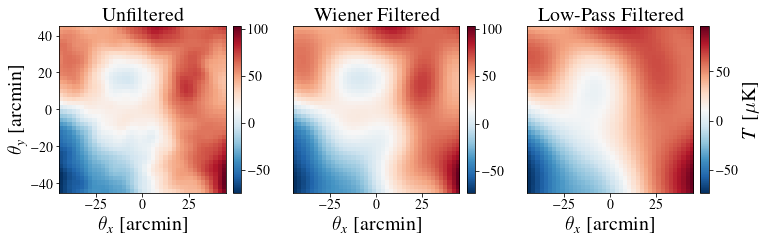

In [9]:
_, extent = tools.make_grid(map_params)
fig, ax = plt.subplots(1,3, figsize=(11,11))


im0 = ax[0].imshow(cmb_map[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cb0 = fig.colorbar(im0, cax = cax)
cb0.ax.tick_params(labelsize=sz_lb)
ax[0].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz_ft)
ax[0].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = sz_ft)
ax[0].set_title('Unfiltered', fontsize = sz_ft)
ax[0].tick_params(labelsize = sz_lb)

im1 = ax[1].imshow(cmb_map_wiener_filtered[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cb1 = fig.colorbar(im1, cax = cax)
cb1.ax.tick_params(labelsize=sz_lb)
ax[1].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz_ft)
ax[1].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = sz_ft)
ax[1].set_title('Wiener Filtered', fontsize = sz_ft)
ax[1].get_yaxis().set_visible(False)
ax[1].tick_params(labelsize = sz_lb)


im2 = ax[2].imshow(cmb_map_low_pass_filtered[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cb2 = fig.colorbar(im2, cax = cax)
cb2.set_label(label=r'$T \ [\mu$'+'K]', size=sz_ft)
cb2.ax.tick_params(labelsize=sz_lb)
ax[2].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz_ft)
ax[2].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = sz_ft)
ax[2].set_title('Low-Pass Filtered', fontsize = sz_ft)
ax[2].get_yaxis().set_visible(False)
ax[2].tick_params(labelsize = sz_lb)


fig.tight_layout(pad=2)
fig.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/effect_of_filters.eps', dpi = 200, bbox_inches = 'tight')

## Pipeline

In [10]:
nber_clus = 30000
nber_rand = 30000
map_params = [180, 0.5, 180, 0.5]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, _ = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, cosmo.concentration_parameter(M200c, 0.7, 0.674), 0.7]
fname = '/Volumes/Extreme_SSD/codes/master_thesis/code/data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 145, uK = True)
tsz_ksz_cutouts = []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout) 

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))


In [5]:
maps_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster, nber_obs = nber_clus)
stack_clus_baseline = lensing_estimator.stack(map_params, maps_clus)
del maps_clus
maps_rand = sims.cmb_mock_data(map_params, l, cl, nber_obs = nber_rand)  
stack_bg = lensing_estimator.stack(map_params, maps_rand)
del maps_rand
maps_clus_tsz_ksz = sims.cmb_mock_data(map_params, l, cl, cluster = cluster, cluster_corr_cutouts = tsz_ksz_cutouts, nber_obs = nber_clus)
stack_clus_tsz_ksz, stack_tsz = lensing_estimator.stack(map_params, maps_clus_tsz_ksz, correct_for_tsz = True)
del maps_clus_tsz_ksz


np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_pipeline_baseline.npy', stack_clus_baseline)  
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_pipeline.npy', stack_bg) 
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_pipeline_tsz_ksz.npy', stack_clus_tsz_ksz) 
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_tsz_pipeline.npy', stack_tsz) 

/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2


In [6]:
map_params = [180, 0.5, 180, 0.5]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200c = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, c200c, 0.7]


cutouts_clus = []
cutouts_clus_aligned = []
for i in range(3):
    map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster)
    cutout = tools.central_cutout(map_params, map_clus, 10)
    cutout -= np.median(cutout)
    cutouts_clus.append(cutout)
    cutouts_clus_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_clus)[0])

    
cutouts_rand = []
cutouts_rand_aligned = []
for i in range(3):
    map_rand = sims.cmb_mock_data(map_params, l, cl)
    cutout = tools.central_cutout(map_params, map_rand, 10)
    cutout -= np.median(cutout)
    cutouts_rand.append(cutout)
    cutouts_rand_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_rand)[0])

with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_pipeline_baseline.npy', 'rb') as file:
    stack_clus_baseline = np.load(file)    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_pipeline.npy', 'rb') as file:
    stack_bg = np.load(file)    
    
    
stack_dipole_baseline = stack_clus_baseline-stack_bg
_, dx, _, _ = map_params
bins = np.arange((-40*dx)/2, (40*dx)/2, dx)
lensing_dipole_profile_baseline = np.mean(stack_dipole_baseline, axis = 0)

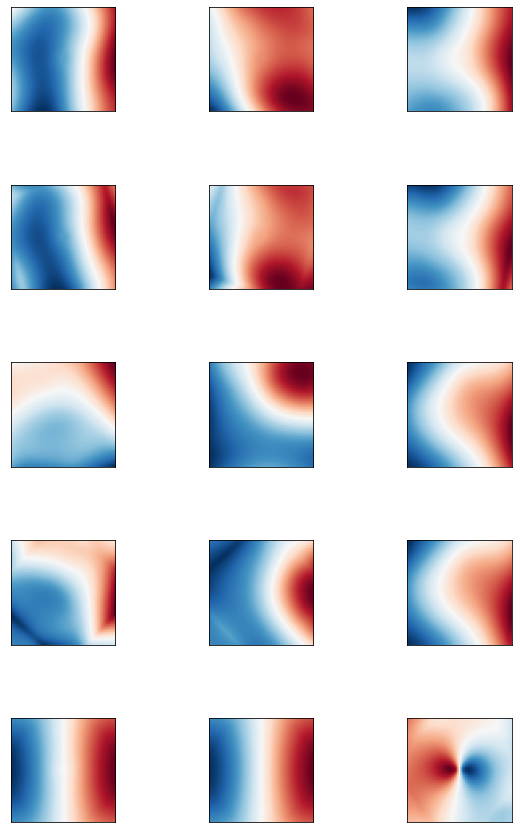

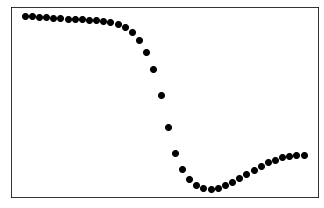

In [7]:
_, extent = tools.make_grid([20, 0.5, 20, 0.5])
fig, axarr = plt.subplots(5,3, figsize=(15,15))


for i in range(3):
    axarr[0,i].imshow(cutouts_clus[i], extent = extent, cmap = cm.RdBu_r)
    axarr[0,i].get_xaxis().set_visible(False)
    axarr[0,i].get_yaxis().set_visible(False)


for i in range(3):
    axarr[1,i].imshow(cutouts_clus_aligned[i], extent = extent, cmap = cm.RdBu_r)
    axarr[1,i].get_xaxis().set_visible(False)
    axarr[1,i].get_yaxis().set_visible(False)


for i in range(3):
    axarr[2,i].imshow(cutouts_rand[i], extent = extent, cmap = cm.RdBu_r)
    axarr[2,i].get_xaxis().set_visible(False)
    axarr[2,i].get_yaxis().set_visible(False)


for i in range(3):
    axarr[3,i].imshow(cutouts_rand_aligned[i], extent = extent, cmap = cm.RdBu_r)
    axarr[3,i].get_xaxis().set_visible(False)
    axarr[3,i].get_yaxis().set_visible(False)


img40 = axarr[4,0].imshow(stack_clus_baseline, extent = extent, cmap = cm.RdBu_r)
axarr[4,0].get_xaxis().set_visible(False)
axarr[4,0].get_yaxis().set_visible(False)
img41 = axarr[4,1].imshow(stack_bg, extent = extent, cmap = cm.RdBu_r)
axarr[4,1].get_xaxis().set_visible(False)
axarr[4,1].get_yaxis().set_visible(False)
img42 = axarr[4,2].imshow(stack_dipole_baseline, extent = extent, cmap = cm.RdBu_r)
axarr[4,2].get_xaxis().set_visible(False)
axarr[4,2].get_yaxis().set_visible(False)

fig.subplots_adjust(wspace= -0.55, hspace = 0.7)

plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/pipeline_cutouts_baseline.png', dpi = 200, bbox_inches = 'tight')


fig, ax = plt.subplots(1,1, figsize=(5.5,3.5))
ax.plot(bins, lensing_dipole_profile_baseline, color = 'black', ls = '', marker = 'o')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/pipeline_profile_baseline.png', dpi = 200, bbox_inches = 'tight')

In [8]:
map_params = [180, 0.5, 180, 0.5]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200c = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, c200c, 0.7]
fname = '/Volumes/Extreme_SSD/codes/master_thesis/code/data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 145, uK = True)
tsz_ksz_cutouts = []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout)  



cutouts_clus = []
cutouts_clus_aligned = []
for i in range(3):
    map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster, cluster_corr_cutouts = tsz_ksz_cutouts)
    cutout = tools.central_cutout(map_params, map_clus, 10)
    cutout -= np.median(cutout)
    cutouts_clus.append(cutout)
    cutouts_clus_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_clus)[0])

    
cutouts_rand = []
cutouts_rand_aligned = []
for i in range(3):
    map_rand = sims.cmb_mock_data(map_params, l, cl)
    cutout = tools.central_cutout(map_params, map_rand, 10)
    cutout -= np.median(cutout)
    cutouts_rand.append(cutout)
    cutouts_rand_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_rand)[0])
    
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_pipeline_tsz_ksz.npy', 'rb') as file:
    stack_clus_tsz_ksz = np.load(file)    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_pipeline.npy', 'rb') as file:
    stack_bg = np.load(file) 
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_tsz_pipeline.npy', 'rb') as file:
    stack_tsz = np.load(file)  
    
stack_dipole_tsz_ksz = stack_clus_tsz_ksz-stack_bg-stack_tsz
_, dx, _, _ = map_params
bins = np.arange((-40*dx)/2, (40*dx)/2, dx)
lensing_dipole_profile_tsz_ksz = np.mean(stack_dipole_tsz_ksz, axis = 0)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2


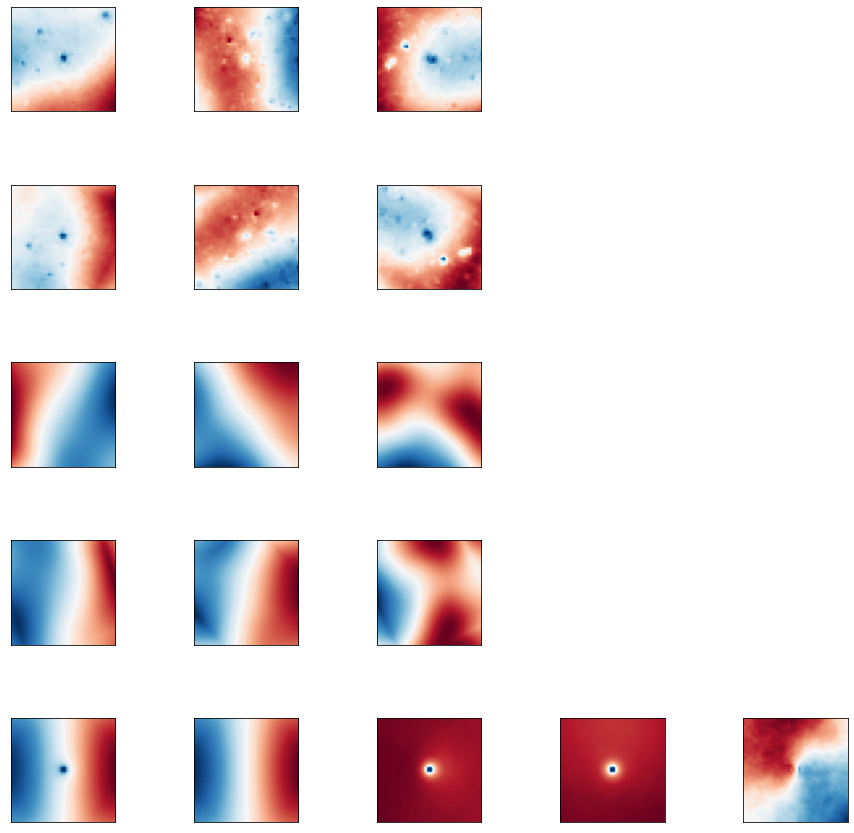

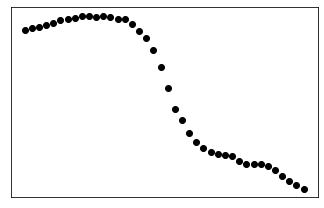

In [9]:
_, extent = tools.make_grid([20, 0.5, 20, 0.5])
fig, axarr = plt.subplots(5,5, figsize=(15,15))


for i in range(3):
    axarr[0,i].imshow(cutouts_clus[i], extent = extent, cmap = cm.RdBu_r)
    axarr[0,i].get_xaxis().set_visible(False)
    axarr[0,i].get_yaxis().set_visible(False)
axarr[0,3].set_visible(False)
axarr[0,4].set_visible(False)


for i in range(3):
    axarr[1,i].imshow(cutouts_clus_aligned[i], extent = extent, cmap = cm.RdBu_r)
    axarr[1,i].get_xaxis().set_visible(False)
    axarr[1,i].get_yaxis().set_visible(False)
axarr[1,3].set_visible(False)
axarr[1,4].set_visible(False)


for i in range(3):
    axarr[2,i].imshow(cutouts_rand[i], extent = extent, cmap = cm.RdBu_r)
    axarr[2,i].get_xaxis().set_visible(False)
    axarr[2,i].get_yaxis().set_visible(False)
axarr[2,3].set_visible(False)
axarr[2,4].set_visible(False)


for i in range(3):
    axarr[3,i].imshow(cutouts_rand_aligned[i], extent = extent, cmap = cm.RdBu_r)
    axarr[3,i].get_xaxis().set_visible(False)
    axarr[3,i].get_yaxis().set_visible(False)
axarr[3,3].set_visible(False)
axarr[3,4].set_visible(False)


axarr[4,0].imshow(stack_clus_tsz_ksz, extent = extent, cmap = cm.RdBu_r)
axarr[4,0].get_xaxis().set_visible(False)
axarr[4,0].get_yaxis().set_visible(False)
axarr[4,1].imshow(stack_bg, extent = extent, cmap = cm.RdBu_r)
axarr[4,1].get_xaxis().set_visible(False)
axarr[4,1].get_yaxis().set_visible(False)
axarr[4,2].imshow(stack_clus_tsz_ksz-stack_bg, extent = extent, cmap = cm.RdBu_r)
axarr[4,2].get_xaxis().set_visible(False)
axarr[4,2].get_yaxis().set_visible(False)
axarr[4,3].imshow(stack_tsz, extent = extent, cmap = cm.RdBu_r)
axarr[4,3].get_xaxis().set_visible(False)
axarr[4,3].get_yaxis().set_visible(False)
axarr[4,4].imshow(stack_dipole_tsz_ksz, extent = extent, cmap = cm.RdBu_r)
axarr[4,4].get_xaxis().set_visible(False)
axarr[4,4].get_yaxis().set_visible(False)


fig.subplots_adjust(wspace= 0.75, hspace = 0.7)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/pipeline_cutouts_tsz_mitigation.png', dpi = 200, bbox_inches = 'tight')


fig, ax = plt.subplots(1,1, figsize=(5.5,3.5))
ax.plot(bins, lensing_dipole_profile_tsz_ksz, color = 'black', ls = '', marker = 'o')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/pipeline_profile_tsz_mitigation.png', dpi = 200, bbox_inches = 'tight')